d_gEDMD = 
  (columns 0 through 7)
     0.00000    -0.70000    -0.80000    -1.40000    -1.50000    -1.60000    -2.10000    -2.20000
phi_1 = -1.000001
phi_2 = 1.28571 x_2 + 1.00000 x_1^2
phi_3 = -1.00000 x_1
phi_4 = 1.65306 x_2^2 + 2.57143 x_1^2 x_2 + 1.00000 x_1^4
phi_5 = 1.28571 x_1 x_2 + 1.00000 x_1^3
phi_6 = -1.00000 x_1^2
phi_7 = 0.31687 x_2^3 + 0.73937 x_1^2 x_2^2 + 0.57506 x_1^4 x_2 + 0.14909 x_1^6
phi_8 = -0.51396 x_1 x_2^2 - 0.79949 x_1^3 x_2 - 0.31091 x_1^5

b_1 = -0.80000 x_1
b_2 = -0.70000 x_2 + 0.70000 x_1^2

W = 
  (columns 0 through 7)
     0.00000    -0.00000     1.00000    -0.00000     0.00000     0.00000    -0.00000     0.00000
     0.00000    -1.26686     0.00000     0.00000     0.00000    -0.77778    -0.00000     0.00000
  (columns 8 through 15)
     0.00000     0.00000     0.00000    -0.00000     0.00000    -0.00000     0.00000    -0.00000
    -0.00000     0.00000     0.00000    -0.00000     0.00000    -0.00000     0.00000    -0.00000
  (columns 16 through 23)
     

/home/tung6100/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


d = 
  (columns 0 through 2)
     0.00000    -0.03557    -2.00000
p = 
  (columns 0 through 7)
     0.00000     1.00000     0.00000     2.00000     1.00000     0.00000     3.00000     2.00000
     0.00000     0.00000     1.00000     0.00000     1.00000     2.00000     0.00000     1.00000
  (columns 8 through 14)
     1.00000     0.00000     4.00000     3.00000     2.00000     1.00000     0.00000
     2.00000     3.00000     0.00000     1.00000     2.00000     3.00000     4.00000
K = 
  (columns 0 through 7)
     0.00000    -0.00000     0.00000     0.49000    -0.00000     0.25000    -0.00000    -0.00000
     0.00000     4.00000    -0.00000    -0.00000     0.50000     0.00000     1.47000    -0.00000
     0.00000     0.00000    -2.00000    -0.00000    -0.00000     0.00000     0.00000     0.49000
     0.00000     0.00000    -0.00000     9.00000     0.00000    -0.00000     0.00000     1.00000
     0.00000     0.00000     0.00000    -0.00000     2.00000    -0.00000     0.00000    -0.00000
  

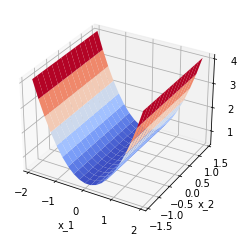

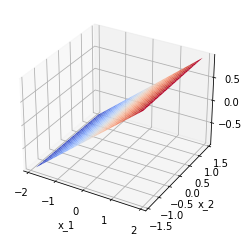

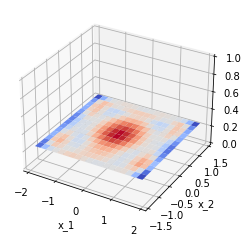

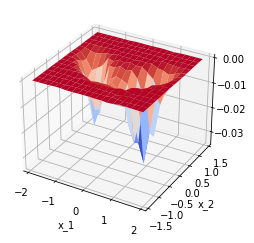

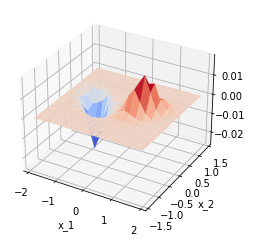

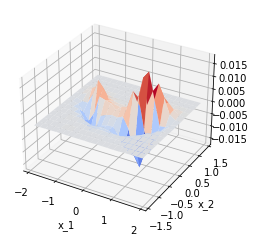

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
import numpy.polynomial
import scipy as sp
import matplotlib.pyplot as plt

from addPath import *
addPath()

from d3s import algorithms
from d3s import domain
from d3s import observables
from d3s import systems


from d3s.tools import printVector, printMatrix

plt.ion()

#%% Simple deterministic system -------------------------------------------------------------------

# define domain
bounds = np.array([[-2, 2], [-2, 2]])
boxes = np.array([50, 50])
Omega = domain.discretization(bounds, boxes)

# define system
gamma = -0.8
delta = -0.7

def b(x):
    return np.array([gamma*x[0, :], delta*(x[1, :] - x[0, :]**2)])

# define observables
psi = observables.monomials(8)

# generate data
X = Omega.rand(1000) # generate test points
Y = b(X)

# apply generator EDMD
evs = 8 # number of eigenvalues/eigenfunctions to be computed
K, d, V = algorithms.gedmd(X, Y, None, psi, evs=evs, operator='K')
# printMatrix(K, 'K_gEDMD')
printVector(np.real(d), 'd_gEDMD')

V[:, 1] /= V[3, 1]; V[:, 3] /= V[10, 3]; V[:, 4] /= V[6, 4] # normalize eigenvectors for convenience
for i in range(evs):
    psi.display(np.real(V[:, i]), 2, 'phi_%d' % (i+1))
print('')

# system identification
B = np.zeros((K.shape[0], Omega.dimension()))
B[1, 0] = 1
B[2, 1] = 1

b_c = K @ B # coefficients of the identified system
psi.display(np.real(b_c[:, 0]), 2, 'b_1')
psi.display(np.real(b_c[:, 1]), 2, 'b_2')
print('')

# system identification 2 (using Koopman modes)
[d, V] = algorithms.sortEig(K, K.shape[0])

W = B.T @ sp.linalg.inv(V).T
printMatrix(np.real(W), 'W')

psi.display( np.real( W[0, 2]*d[2]*V[:, 2] ), 2, 'b_1')
psi.display( np.real( W[1, 1]*d[1]*V[:, 1] + W[1, 5]*d[5]*V[:, 5]) , 2, 'b_2')

#%% pendulum conservation laws --------------------------------------------------------------------

# define domain
bounds = np.array([[-2, 2], [-2, 2]])
boxes = np.array([50, 50])
Omega = domain.discretization(bounds, boxes)

# define system
def b(x):
    return np.vstack((x[1, :], -np.sin(x[0, :])))

# define observables
class poltrig(object):
    def __init__(self):
        self.p = observables.monomials(2)
    
    def __call__(self, x):
        return np.vstack((self.p(x), np.sin(x[0, :]), np.cos(x[0, :]), np.sin(x[1, :]), np.cos(x[1, :])))
    
    def diff(self, x):
        dp = self.p.diff(x)
        (n1, n2, n3) = dp.shape
        y = np.zeros((n1+4, n2, n3))
        y[:-4, :, :] = dp
        y[-4, 0, :] =  np.cos(x[0, :])
        y[-3, 0, :] = -np.sin(x[0, :])
        y[-2, 1, :] =  np.cos(x[1, :])
        y[-1, 1, :] = -np.sin(x[1, :])
        return y

psi = poltrig()

# generate data
X = Omega.rand(1000) # generate test points
Y = b(X)

# apply generator EDMD
evs = 5 # number of eigenvalues/eigenfunctions to be computed
K, d, V = algorithms.gedmd(X, Y, None, psi, evs=evs, operator='K')
printMatrix(K, 'K_gEDMD')
printVector(np.real(d), 'd_gEDMD')
printMatrix(np.real(V), 'V')

#%% Ornstein-Uhlenbeck process --------------------------------------------------------------------

# define domain
bounds = np.array([[-2, 2]])
boxes = np.array([1000])
Omega = domain.discretization(bounds, boxes)

# define system
alpha = 1
beta = 4

def b(x):
    return -alpha*x

def sigma(x):
    return np.sqrt(2/beta)*np.ones((1, 1, x.shape[1]))

# Euler-Maruyama integrator for Ornstein-Uhlenbeck (for comparison with EDMD; make sure the same parameters are used)
h = 0.001
tau = 0.5
f = systems.OrnsteinUhlenbeck(h, int(tau/h))

# define observables
psi = observables.monomials(10)

# generate data
X = Omega.rand(10000)
Y1 = b(X)
Z1 = sigma(X)
Y2 = f(X) # integration of the SDE, for standard EDMD

# apply generator EDMD
evs = 5 # number of eigenvalues/eigenfunctions to be computed
K1, d1, V1 = algorithms.gedmd(X, Y1, Z1, psi, evs=evs, operator='K')
printMatrix(K1, 'K_gEDMD')
printVector(np.real(d1), 'd_gEDMD')

# apply standard EDMD
K2, d2, V2 = algorithms.edmd(X, Y2, psi, evs=evs, operator='K')
printVector(1/tau*np.log(np.real(d2)), 'd_EDMD')

# collect results
c = Omega.midpointGrid()
R1 = V1.T @ psi(c) # gEDMD eigenfunctions
R2 = V2.T @ psi(c) #  EDMD eigenfunctions
R3 = np.zeros((evs, c.shape[1]))
for i in range(evs):
    q = np.zeros((evs,))
    q[i] = 1
    he = np.polynomial.hermite_e.HermiteE(q)
    R3[i, :] = he(np.sqrt(alpha*beta)*c) # rescaled probabilists' Hermite polynomials
    
    # normalize
    R1[i, :] = R1[i, :]/np.amax(abs(R1[i, :]))
    R2[i, :] = R2[i, :]/np.amax(abs(R2[i, :]))
    R3[i, :] = R3[i, :]/np.amax(abs(R3[i, :]))

# plot results
plt.figure(1)
plt.clf()
plt.plot(c.T, R1.T)
plt.title('gEDMD')
plt.legend([ 'phi_%i'% (i+1) for i in range(evs) ])

plt.figure(2)
plt.clf()
plt.plot(c.T, R2.T)
plt.title('EDMD')
plt.legend([ 'phi_%i'% (i+1) for i in range(evs) ])

plt.figure(3)
plt.clf()
plt.plot(c.T, R3.T)
plt.title('True solution')
plt.legend([ 'phi_%i'% (i+1) for i in range(evs) ])

#%% Double-well system ---------------------------------------------------------------------------

# define domain
bounds = np.array([[-2, 2], [-1.5, 1.5]])
boxes = np.array([20, 15])
Omega = domain.discretization(bounds, boxes)

# define system
def b(x):
     return np.vstack((-4*x[0, :]**3 + 4*x[0, :], -2*x[1, :]))
 
def sigma(x):
    n = x.shape[1]
    y = np.zeros((2, 2, n))
    y[0, 0, :] = 0.7
    y[0, 1, :] = x[0, :]
    y[1, 1, :] = 0.5
    return y

# define observables
order = 10
psi = observables.monomials(order)

# generate data
X = Omega.randPerBox(100)
Y = b(X)
Z = sigma(X)

# apply generator EDMD
evs = 3 # number of eigenvalues/eigenfunctions to be computed
K, d, V = algorithms.gedmd(X, Y, Z, psi, evs=evs, operator='K')
printVector(np.real(d), 'd')

# plot eigenfunctions
c = Omega.midpointGrid()
Psi_c = psi(c)
for i in range(evs):
    plt.figure(i+1);
    plt.clf()
    Omega.plot(np.real( V[:, i].T @ Psi_c ), mode='3D')
    
#%% system identification
order = 4 # reduce order of monomials
p = observables.allMonomialPowers(2, order)
n = p.shape[1] # number of monomials up to order 4

printMatrix(p, 'p')
printMatrix(K[:n, :n], 'K')

# compute entries of a evaluated in c
b_c = K[:, 1:3].T @Psi_c

a_11 = K[:, 3].T @ Psi_c - 2*b_c[0, :]*c[0, :]
a_12 = K[:, 4].T @ Psi_c - b_c[0, :]*c[1, :] - b_c[1, :]*c[0, :]
a_22 = K[:, 5].T @ Psi_c - 2*b_c[1, :]*c[1, :]

plt.figure(evs+1)
Omega.plot(a_11, mode='3D')
plt.figure(evs+2)
Omega.plot(a_12, mode='3D')
plt.figure(evs+3)
Omega.plot(a_22, mode='3D')
plt.gca().set_zlim([0, 1])

#%% Perron-Frobenius generator

# define observables
psi = observables.gaussians(Omega, 0.2)

# apply generator EDMD
evs = 3 # number of eigenvalues/eigenfunctions to be computed
K, d, V = algorithms.gedmd(X, Y, Z, psi, evs=evs, operator='P')
printVector(np.real(d), 'd')

# plot eigenfunctions
c = Omega.midpointGrid()
Psi_c = psi(c)
for i in range(evs):
    plt.figure(i+1);
    plt.clf()
    Omega.plot(np.real( V[:, i].T @ Psi_c ), mode='3D')
